# Test du Dataset sur les vins espagnols

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

/Users/sqallihadi/.pyenv/versions/simplon/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


- import du DF
- suppression de 'country'
- suppression des NaN

In [3]:
df = pd.read_csv('wines_SPA.csv')
df.drop('country',axis=1,inplace=True)


In [4]:
df.isna().any()

winery         False
wine           False
year            True
rating         False
num_reviews    False
region         False
price          False
type            True
body            True
acidity         True
dtype: bool

## 'Year' : 2 lignes manquantes
## 'type','body','acidity' : 545 mêmes lignes manquantes

In [50]:
#df[df['year'].isna()]
#(df['type'].isna() == df['acidity'].isna()).any()
#(df['type'].isna() == df['body'].isna()).any()

# 1 - Preprocessing : Data cleaning

## 1.1 - On drop les valeurs nulles (on pourra éventuellement interpoler les valeurs body/acid en moyennant, voir si ça améliore les prédictions)

In [5]:
df.dropna(inplace=True)

In [52]:
df

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...
7495,Contino,Reserva,2016,4.2,392,Rioja,19.98,Rioja Red,4.0,3.0
7496,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Priorato,16.76,Priorat Red,4.0,3.0
7497,Mustiguillo,Finca Terrerazo,2017,4.2,390,El Terrerazo,24.45,Red,4.0,3.0
7498,Matarromera,Gran Reserva,2011,4.2,389,Ribera del Duero,64.50,Ribera Del Duero Red,5.0,3.0


In [53]:
df.type.unique()

array(['Toro Red', 'Tempranillo', 'Ribera Del Duero Red', 'Pedro Ximenez',
       'Red', 'Sherry', 'Priorat Red', 'Rioja Red', 'Rioja White',
       'Grenache', 'Cava', 'Verdejo', 'Syrah', 'Monastrell', 'Mencia',
       'Sparkling', 'Montsant Red', 'Albarino', 'Chardonnay',
       'Cabernet Sauvignon', 'Sauvignon Blanc'], dtype=object)

In [54]:
print('nombre de producteurs différents :',df.winery.nunique())
print('nombre de vins différents :',df.wine.nunique())
print('types de vins différents :',df.type.nunique())
print('nombre de régions différentes :',df.region.nunique())

nombre de producteurs différents : 425
nombre de vins différents : 738
types de vins différents : 21
nombre de régions différentes : 66


### Quantité de vins du Dataset en fonction du nom des régions : (15 premiers)

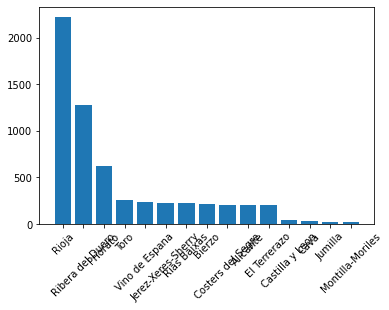

In [55]:
plt.bar(df.region.value_counts().index[:15],df.region.value_counts().tolist()[:15])
plt.xticks(rotation=45)
plt.show()

## 1.2 - réduction feature 'region'  de 21 à 10

### Au delà des 10 régions les + productrices, la quantité de vins recensés diminue. On peut décider de ***réduire** les régions ***aux 10 premières**** (les plus productrices de vins) + on regroupe dans 'Other_region' toutes les autres

In [56]:
top10regions = df.region.value_counts().index[:10]

df['region'] = df['region'].apply(lambda x: x if x in top10regions else 'Other_region')

## 1.3 - Suppression colonnes 'wine' et 'winery' : trop de valeurs uniques

In [57]:
len(df[df['year']=='N.V.']) # nombre de 'N.V.' pour les années -> s'en débarrasser

259

## 1.4 - Suppression valeurs inutiles d'années : on drop les valeurs 'N.V'

In [58]:
df.drop(df[df['year']=='N.V.'].index, inplace=True)

## 1.5 - Reformattage colonne 'year' en integer

In [59]:
df['year'] = df['year'].astype('int16')

## 1.6 (facultatif) On remplace les 66 régions par des valeurs numériques (pour checker sur la heatmap)

In [60]:
#df['region_encoded'] = df['region'].apply(lambda x: [i for i,j in enumerate(df['region'].unique()) if j==x][0])

In [61]:
#df['region_encoded'].tolist() == LabelEncoder().fit_transform(df['region']).tolist()

### Le 'LabelEncoder' fait automatiquement le taffe pour encoder les régions

In [62]:
LabelEncoder().fit_transform(df['region']) 

array([ 9, 10,  7, ...,  4,  7,  7])

In [63]:
df.head()

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


## 1.7 - Affichage de certaines features

### 1.7.1 - scatterplot prix/années, scatterplot prix/ratings

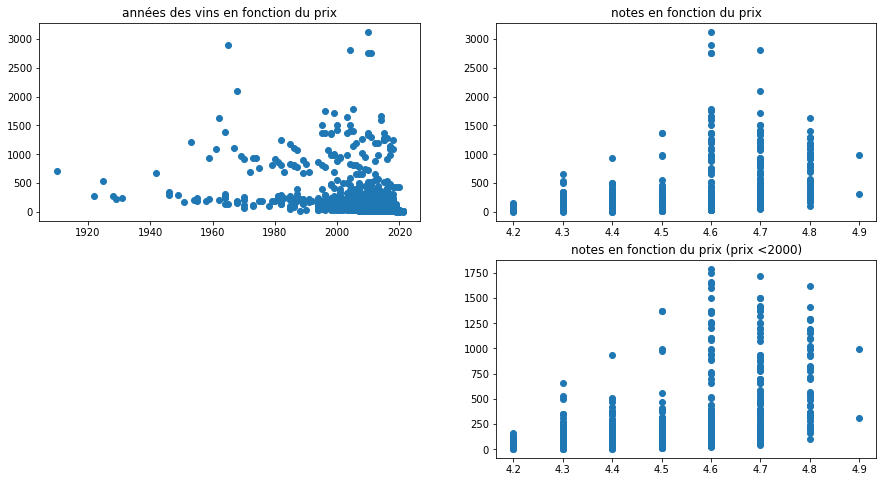

In [64]:
#fig, axs = plt.subplots(2,2, figsize=(15,8),sharex='col')
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221)
ax1.scatter(df.year, df.price)
ax1.set_title('années des vins en fonction du prix')
ax2 = plt.subplot(222)
ax2.scatter(df.rating, df.price)
ax2.set_title('notes en fonction du prix')
ax3 = plt.subplot(223)
ax3.set_visible(False)
ax4 = plt.subplot(224,sharex=ax2) #sharex ne veut pas marcher....!!!!!
ax4.scatter(df[df['price']<2000]['rating'],df[df['price']<2000]['price'])
ax4.set_title('notes en fonction du prix (prix <2000)')

plt.show()

### 1.7.2 - Pairplot

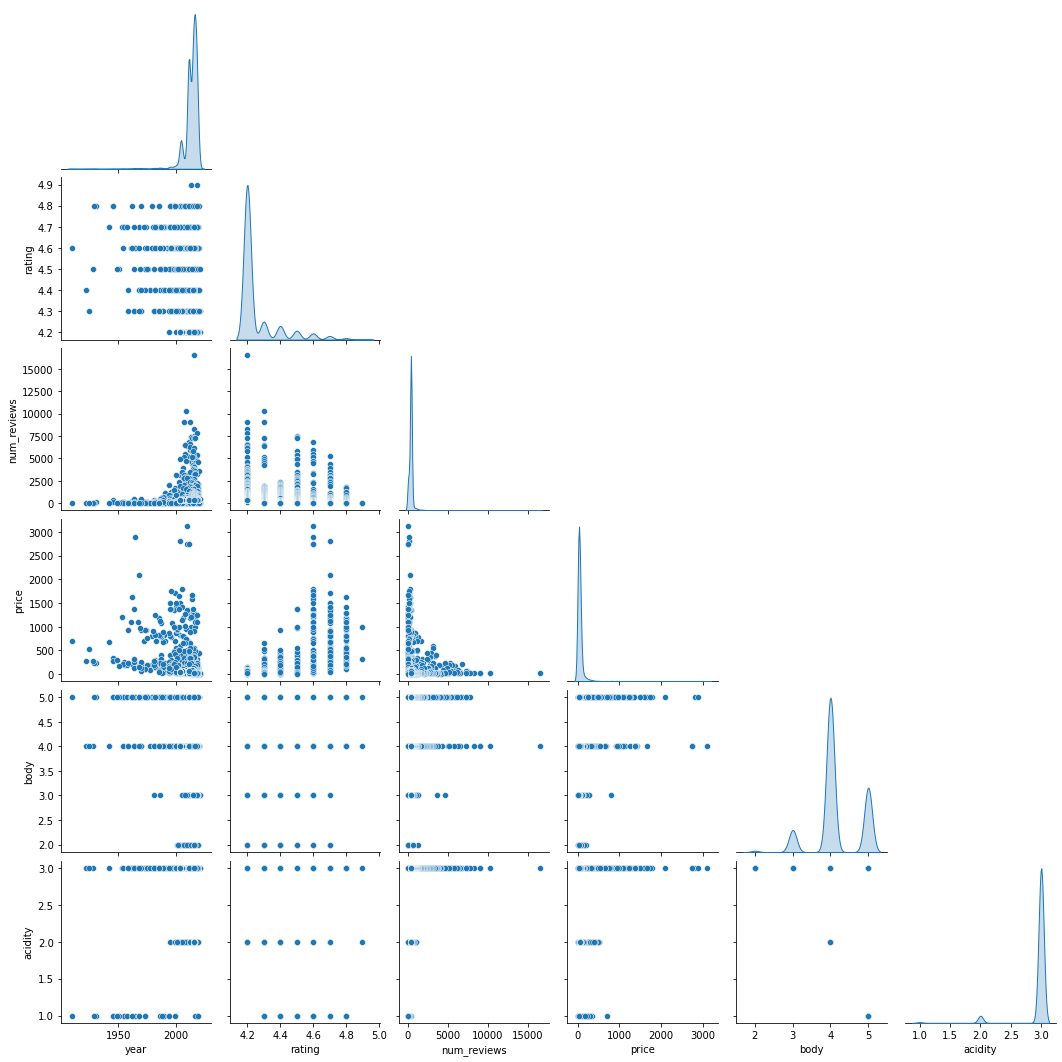

In [20]:
sns.pairplot(df.drop(['region','type'],axis=1),diag_kind='kde', corner=True) #corner=True : évite l'affichage de la partie symétrique
plt.show()

### Quelques analyses après visualisation pairplot

### *Les features "acidity" et "body" peuvent être vues comme des valeurs catégorielles : elles sont discrètes et prennent respectivement 3 et 4 valeurs*

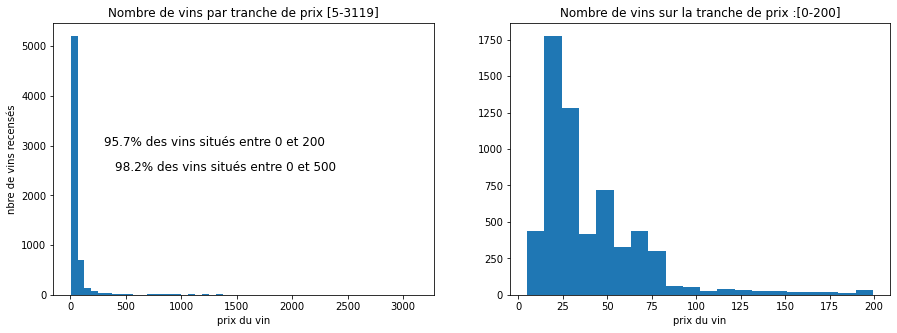

In [29]:
# je veux voir par tranche de prix combien de vins sont recensés:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(df.price, bins=50)
ax1.set_xlabel('prix du vin')
ax1.set_ylabel('nbre de vins recensés')
ax1.set_title(f"Nombre de vins par tranche de prix [{round(min(df.price))}-{round(max(df.price))}]",fontsize=12)
ax1.annotate(f'{round(df.price[df.price<200].count()/len(df.price)*100,1)}% des vins situés entre 0 et 200',
             xy=(1300, 3000),fontsize=12,ha='center')
ax1.annotate(f'{round(df.price[df.price<500].count()/len(df.price)*100,1)}% des vins situés entre 0 et 500',
             xy=(1400, 2500),fontsize=12,ha='center')
ax2.hist(df.price[df.price<200],bins=20)
ax2.set_xlabel('prix du vin')
ax2.set_title(f"Nombre de vins sur la tranche de prix :[0-200]",fontsize=12)

plt.show()

## Prix/Ratings distribués selon une loi de Poisson ? Exponentielle ? Fisher ?

In [11]:
from scipy.stats import skew
print(skew(df.price))
print(df.price.skew())

8.929676817597676
8.931793830217902


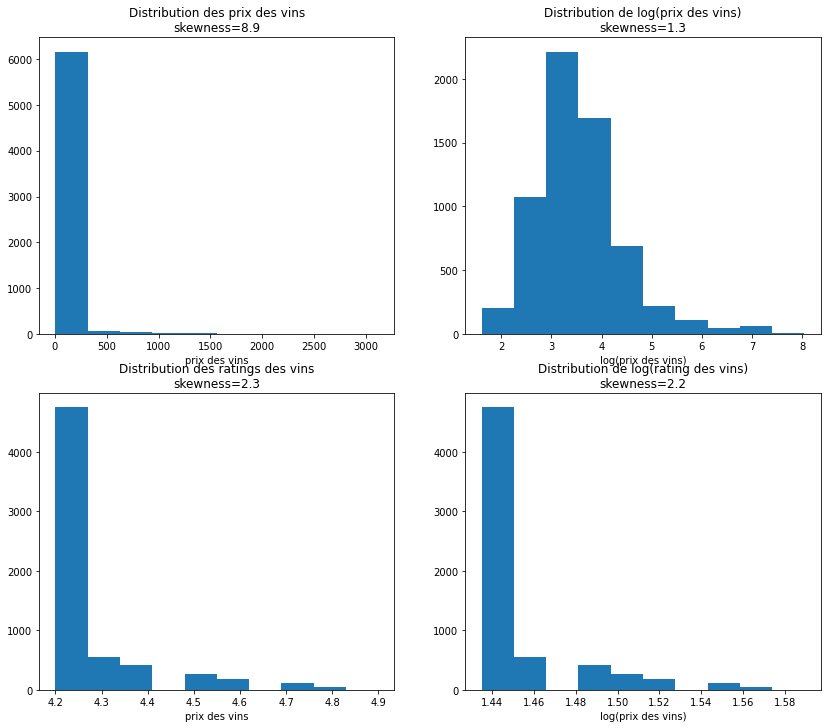

In [28]:
_, axs = plt.subplots(2,2,figsize=(14,12))
axs[0,0].hist(df.price)
axs[0,0].set(title=f"Distribution des prix des vins\nskewness={round(df.price.skew(),1)}",
        xlabel="prix des vins")
axs[0,1].hist(np.log(df.price))
axs[0,1].set(title=f"Distribution de log(prix des vins)\nskewness={round(np.log(df.price).skew(),1)}",
        xlabel="log(prix des vins)")

axs[1,0].hist(df.rating)
axs[1,0].set(title=f"Distribution des ratings des vins\nskewness={round(df.rating.skew(),1)}",
        xlabel="prix des vins")
axs[1,1].hist(np.log(df.rating))
axs[1,1].set(title=f"Distribution de log(rating des vins)\nskewness={round(np.log(df.rating).skew(),1)}",
        xlabel="log(prix des vins)")
plt.show()

## 1.8 - Heatmap 

### Heatmap de la matrice de corrélation avec toutes les features numériques:
### Heatmap de la matrice de corrélation en retirant la feature 'price' pour mieux comprendre le reste des corrélations possibles

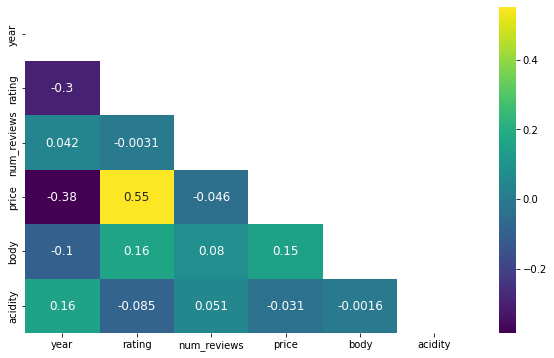

In [66]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap='viridis', mask=np.triu(df.corr()),annot_kws={"fontsize":12},annot=True)
plt.show()

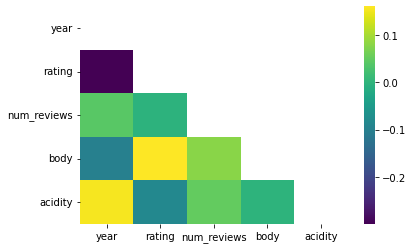

In [68]:
sns.heatmap(df.drop('price',axis=1).corr(),cmap='viridis',mask=np.triu(df.drop('price',axis=1).corr()))
plt.show()

## 1.9 - et si je prenait la version filtrée du df en dégageant les lignes avec prix>500 ?

In [69]:
df_500 = df[df.price<500]
df.head()

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [70]:
print(len(df_500), len(df))

5959 6070


In [1]:
df.columns

NameError: name 'df' is not defined

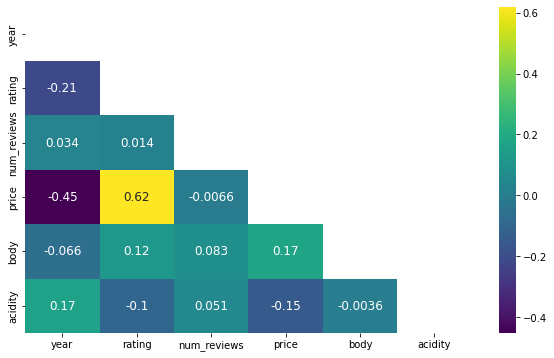

In [26]:
plt.figure(figsize=(10,6))
sns.heatmap(df_500.corr(),cmap='viridis', mask=np.triu(df_500.corr()),annot_kws={"fontsize":12},annot=True)
plt.show()
# on observe que la corrélation "PRICE/RATING" s'améliore


## 2.0 - Régression linéaire simple sur (x=rating/y=price):

/Users/sqallihadi/.pyenv/versions/simplon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


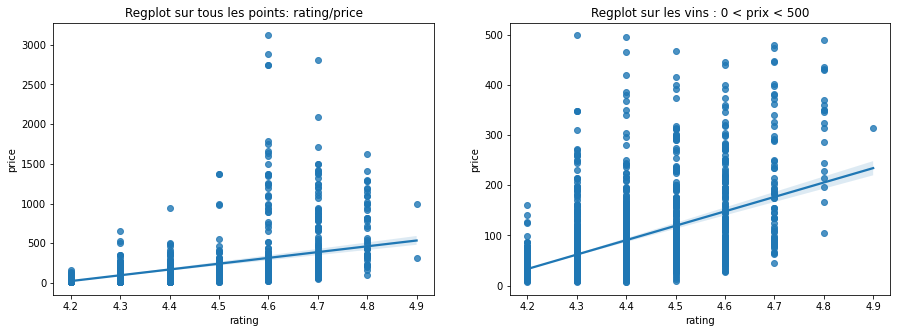

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.regplot(df.rating,df.price,ax=ax1)
ax1.set_title("Regplot sur tous les points: rating/price")
sns.regplot(df_500.rating,df_500.price,ax=ax2)
ax2.set_title("Regplot sur les vins : 0 < prix < 500")
plt.show()

In [28]:
a,b = np.polyfit(df_500.rating,df_500.price,deg=1)

#y_pred = 

def calculate_r2(y_mes, y):    
    result = 1 - (sum((y_mes - y)**2)/sum((y_mes - y_mes.mean())**2))
    return result    

# 2 - Création Pipeline pour modèle LR

## 2.1 - Fonction (crédits à Hugues) pour créer un Pipeline complet automatisé de ML


In [71]:
def make_mix_pipeline(scaler=MinMaxScaler(), model=LinearRegression()):
    num_transformer = Pipeline([(f'scaler:{scaler}', scaler)])
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_features = make_column_selector(dtype_include = np.number)
    cat_features = make_column_selector(dtype_exclude = np.number)
    preprocessing_transformer = ColumnTransformer([('num columns',num_transformer, numerical_features),('cat columns',cat_transformer, cat_features)])
    pipeline_workflow = Pipeline([('preprocessing_tranformer', preprocessing_transformer),(f'{model}', model)])
    return pipeline_workflow

In [29]:
df.dtypes

year             int16
rating         float64
num_reviews      int64
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object

In [88]:
y = df['price']                  # Le vecteur y (variable expliquée) correspond à la colonne 'rating'
X = df.drop(columns=['price'])   # La matrice X (variables explicatives) correspond aux autres colonnes

In [89]:
# La fonction train_test_split() permet de créer X_train, X_test, y_train et y_test automatiquement

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

## 2.1.1 - Pipeline - Régression linéaire avec minmaxscaler, ohe

In [106]:

first_pred = make_mix_pipeline() #minmax, reglin
first_pred.fit(X_train, y_train)
first_score = first_pred.score(X_test, y_test)
first_cv = cross_val_score(first_pred, X_train, y_train, cv=5, scoring='r2')
print(f"score de prédiction sur le jeu de test :{np.round(first_score,2)}")
print(f"scores de cross-validation : {np.round(first_cv,2)}")
print(f"moyenne des scores de cv: {np.round(first_cv.mean(),2)}")

score de prédiction sur le jeu de test :0.85
scores de cross-validation : [0.61 0.61 0.6  0.86 0.71]
moyenne des scores de cv: 0.68


### Commentaire succinct: 
La cross-validation montre que la prédiction n'est pas homogène selon les sous-groupes testés, le score affiché est très possiblement overfitté.

## 2.1.2 - En ne gardant que 'wine' et 'winery' ?

In [46]:
df.columns

Index(['year', 'rating', 'num_reviews', 'region', 'price', 'type', 'body',
       'acidity'],
      dtype='object')

In [86]:
y2 = df['price']                  # Le vecteur y (variable expliquée) correspond à la colonne 'rating'
X2 = df[['wine','winery']]   # La matrice X (variables explicatives) correspond aux autres colonnes

# La fonction train_test_split() permet de créer X_train, X_test, y_train et y_test automatiquement

X_train2, X_test2, y_train2, y_test2= train_test_split(X2, y2, test_size=0.3) 

In [92]:
second_pred = make_mix_pipeline()
second_pred.fit(X_train2,y_train2)
second_score = second_pred.score(X_test2,y_test2)
second_cv = cross_val_score(second_pred, X_train2, y_train2, cv=5, scoring='r2')

print(f"score de prédiction sur le jeu de test :{second_score}")
print(f"scores de cross-validation : {second_cv}")
print(f"moyenne des scores de cv: {second_cv.mean()}")

score de prédiction sur le jeu de test :0.7605836054004711
scores de cross-validation : [0.46282812 0.57558629 0.71217939 0.7841048  0.70487048]
moyenne des scores de cv: 0.6479138174390623


In [85]:
X_test

,wine,winery
3117,Valdegines,Artadi
4649,El Puntido,Vinedos de Paganos
76,La Nieta,Vinedos de Paganos
405,Pago de Santa Cruz,Vina Sastre
2202,Roc Nu,Clos Pons
...,...,...
7127,Santa Rosa,Enrique Mendoza
3753,Coleccion Privada,Sierra Cantabria
5838,Clos del Portal Somni,Portal del Priorat
222,Nit de Nin Mas d'en Cacador,Nin-Ortiz


## 2.3 - Quelques graphs

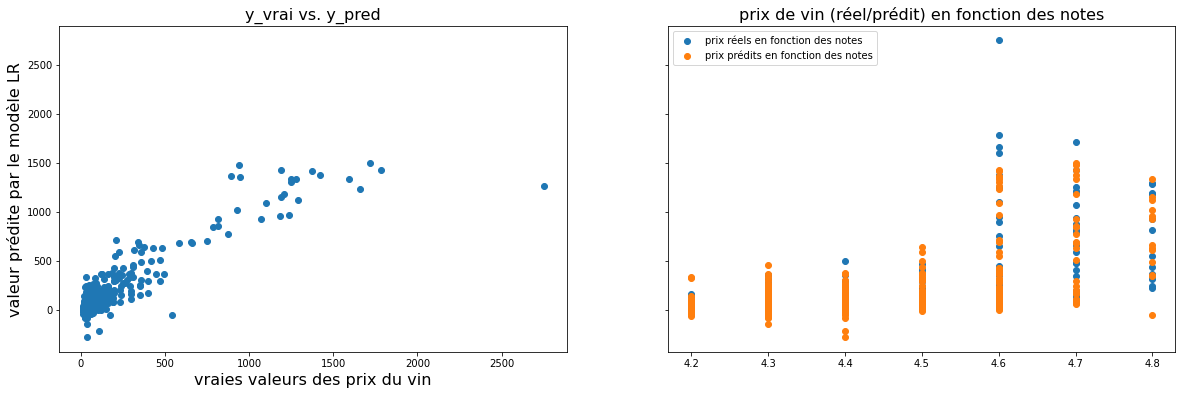

In [91]:
y_pred = first_pred.predict(X_test)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6),sharey=True)
ax1.scatter(y_test,y_pred)
ax1.set_xlabel('vraies valeurs des prix du vin', fontsize=16)
ax1.set_ylabel('valeur prédite par le modèle LR', fontsize=16)
ax1.set_title("y_vrai vs. y_pred", fontsize=16)

ax2.scatter(X_test['rating'],y_test,label='prix réels en fonction des notes')
ax2.scatter(X_test['rating'],y_pred, label='prix prédits en fonction des notes')
ax2.set_title("prix de vin (réel/prédit) en fonction des notes", fontsize=16)
plt.legend(loc='upper left',fontsize=10)
plt.show()

In [113]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

Remove_Outlier_Indices(df)

/var/folders/99/7zwt_pz57n96z_6ygkrh50080000gn/T/ipykernel_885/2813943653.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))


acidity        True
body           True
num_reviews    True
price          True
rating         True
region         True
type           True
wine           True
winery         True
year           True
dtype: bool

In [175]:
df.drop_duplicates()[df.drop_duplicates()['num_reviews']> q3+1.5*iqr]['num_reviews']

2       1793
3       1705
4       1309
5       1209
6       1201
        ... 
1877    1319
1878    1308
1879    1301
1880    1267
1881    1209
Name: num_reviews, Length: 184, dtype: int64

<AxesSubplot: xlabel='price'>

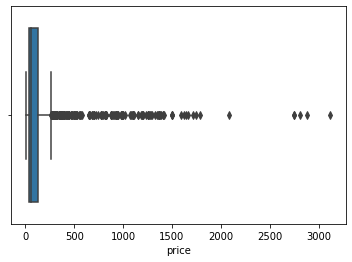

In [190]:
sns.boxplot(data=df.drop_duplicates(),x='price')


In [ ]:
df.price.hist()


In [194]:
df.drop_duplicates()['num_reviews']

0         58
1         31
2       1793
3       1705
4       1309
        ... 
2045     390
2046     390
2047     389
2048     388
2049     384
Name: num_reviews, Length: 1714, dtype: int64

q1:56.0, inf: -608.5, q3:499.0, sup: 1163.5
number of reviews: mean: 538.023661971831, median:134.0


/var/folders/99/7zwt_pz57n96z_6ygkrh50080000gn/T/ipykernel_14666/1326414537.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axs[2].scatter(df2[~nr_o]['num_reviews'],df2[~nr_o]['price'],c='gray')
/var/folders/99/7zwt_pz57n96z_6ygkrh50080000gn/T/ipykernel_14666/1326414537.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axs[2].scatter(df2[nr_o]['num_reviews'],df2[nr_o]['price'],c='r')
/var/folders/99/7zwt_pz57n96z_6ygkrh50080000gn/T/ipykernel_14666/1326414537.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axs[2].scatter(df2[p_o]['num_reviews'],df2[p_o]['price'],c='r')


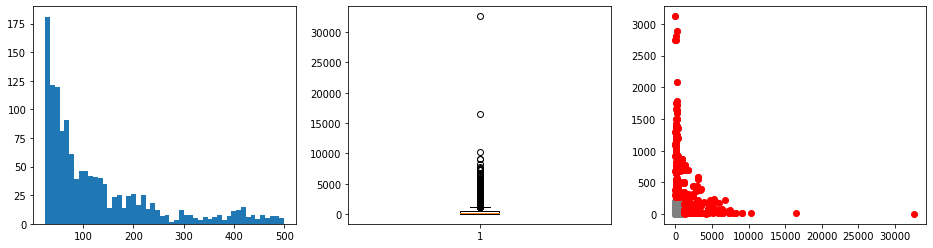

In [6]:

df2 = df.drop_duplicates()
#df2['colors'] = [c for c, _ in zip(color_cycle, range(len(df2)))]

q1 = df2['num_reviews'].quantile(.25)
q3 = df2['num_reviews'].quantile(.75)
iqr = q3-q1
print(f"q1:{q1}, inf: {q1-1.5*iqr}, q3:{q3}, sup: {q3+1.5*iqr}")
print(f"number of reviews: mean: {df2['num_reviews'].mean()}, median:{df2['num_reviews'].median()}")
f, axs = plt.subplots(1,3,figsize=(16,4))
axs[0].hist(df2[df2['num_reviews']<500]['num_reviews'],bins=50)
axs[1].boxplot(df2['num_reviews'])
#axs[2].boxplot(df.drop_duplicates()[df.drop_duplicates()['num_reviews']< q3+1.5*iqr]['num_reviews'])

nr_o = df.num_reviews > q3+1.5*iqr
p_o = df.price > df2.price.quantile(.75)+1.5*(df2.price.quantile(.75)-df2.price.quantile(.25))
axs[2].scatter(df2[~nr_o]['num_reviews'],df2[~nr_o]['price'],c='gray')
axs[2].scatter(df2[nr_o]['num_reviews'],df2[nr_o]['price'],c='r')
axs[2].scatter(df2[p_o]['num_reviews'],df2[p_o]['price'],c='r')

plt.show()


<AxesSubplot: >

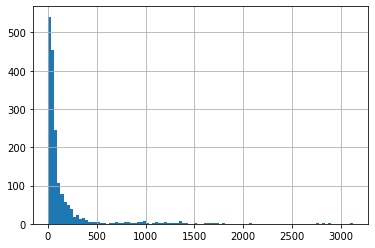

In [8]:
df2['price'].hist(bins=100)

q1:33.0, inf: -105.05624999999998, q3:125.0375, sup: 263.09375
number of reviews: mean: 151.13690784276835, median:58.095


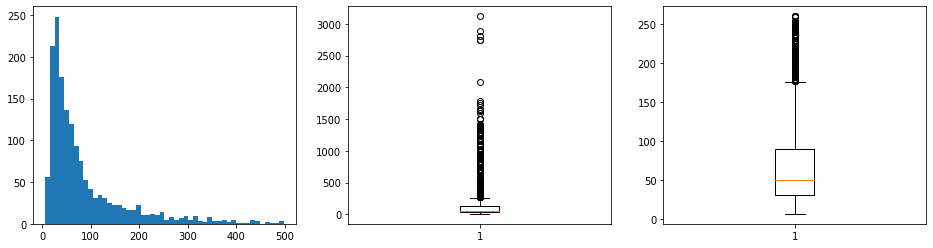

0

In [182]:
q1 = df.drop_duplicates()['price'].quantile(.25)
q3 = df.drop_duplicates()['price'].quantile(.75)
iqr = q3-q1
print(f"q1:{q1}, inf: {q1-1.5*iqr}, q3:{q3}, sup: {q3+1.5*iqr}")
print(f"number of reviews: mean: {df.drop_duplicates()['price'].mean()}, median:{df.drop_duplicates()['price'].median()}")
f, axs = plt.subplots(1,3,figsize=(16,4))
axs[0].hist(df.drop_duplicates()[df.drop_duplicates()['price']<500]['price'],bins=50)
axs[1].boxplot(df.drop_duplicates()['price'])
axs[2].boxplot(df.drop_duplicates()[df.drop_duplicates()['price']< q3+1.5*iqr]['price'])
plt.show()
(df.drop_duplicates()['price'] < q1-1.5*iqr).sum()

In [30]:
!pip install geolocation-python

  Preparing metadata (setup.py) ... done
  Created wheel for geolocation-python: filename=geolocation_python-0.2.2-py3-none-any.whl size=10839 sha256=a46ddc985f8aca1550280b3d8b3d7517d0dc54235b6f6e59280e00faa6158af4
  Stored in directory: /Users/sqallihadi/Library/Caches/pip/wheels/47/9f/db/4b971302a7f7e97b8101c3670576f1670513fed8b12989fc8b
Successfully built geolocation-python


In [33]:
import requests

def get_coordinates(place_name):
    
    endpoint = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": place_name,
        "format": "json",
        "limit": 1
    }
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 0:
            latitude = data[0]["lat"]
            longitude = data[0]["lon"]
            return (latitude, longitude)
    return None



In [71]:
coordinates = {}
for index, row in enumerate(df2['region'].unique()):
    place_name = row
    coordinates[row] = get_coordinates(place_name)
print(coordinates)

{'Toro': ('41.5216963', '-5.3939824'), 'Vino de Espana': ('42.1771554', '-8.4341104'), 'Ribera del Duero': ('41.66575665', '-3.686329463971761'), 'Montilla-Moriles': ('36.7286168', '-4.3001727'), 'Jumilla': ('38.4735408', '-1.3285417'), 'Jerez-Xeres-Sherry': ('36.65901315', '-6.155439431926194'), 'Priorato': ('44.8741121', '10.1628956'), 'Rioja': ('42.2814642', '-2.482804975070473'), 'Bierzo': ('42.65265025', '-6.62318404217132'), 'Castilla y Leon': ('41.8037172', '-4.7471726'), 'Campo de Borja': ('41.78654145', '-1.5058322706803928'), 'Cava': ('42.31658175', '1.6111496867672197'), 'Jerez Palo Cortado': ('36.6954668', '-6.1474169'), 'Manzanilla': ('37.3887479', '-6.4316237'), 'Emporda': ('42.1893929', '3.077661284375413'), 'Rioja Alta': ('42.4157318', '-2.87947386168831'), 'Somontano': ('42.0883878', '0.09940412890672314'), 'Dominio de Valdepusa': None, 'Mallorca': ('39.613432', '2.880353635614984'), 'Yecla': ('38.613652', '-1.1157373'), 'Cigales': ('41.7582863', '-4.6989785'), 'Utiel-

In [78]:
latitudes = {}
longitudes = {}
for k,v in coordinates.items():
    if v != None:
        latitudes[k] = v[0]
        longitudes[k] = v[1]

In [81]:
latitudes['Dominio de Valdepusa']

KeyError: 'Dominio de Valdepusa'

In [56]:
df2.shape

(1775, 12)

In [90]:
df2['latitude'] = df2['region'].apply(lambda x: None if x not in latitudes else latitudes[str(x)])
df2['longitude'] = df2['region'].apply(lambda x: None if x not in longitudes else longitudes[str(x)] )

/var/folders/99/7zwt_pz57n96z_6ygkrh50080000gn/T/ipykernel_14666/2113609270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['latitude'] = df2['region'].apply(lambda x: None if x not in latitudes else latitudes[str(x)])
/var/folders/99/7zwt_pz57n96z_6ygkrh50080000gn/T/ipykernel_14666/2113609270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['longitude'] = df2['region'].apply(lambda x: None if x not in longitudes else longitudes[str(x)] )


In [91]:
df2

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity,latitude,longitude
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0,41.5216963,-5.3939824
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0,42.1771554,-8.4341104
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0,41.66575665,-3.686329463971761
3,Vega Sicilia,Unico,1999,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0,41.66575665,-3.686329463971761
4,Vega Sicilia,Unico,1996,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0,41.66575665,-3.686329463971761
...,...,...,...,...,...,...,...,...,...,...,...,...
2045,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Priorato,16.76,Priorat Red,4.0,3.0,44.8741121,10.1628956
2046,Mustiguillo,Finca Terrerazo,2017,4.2,390,El Terrerazo,24.45,Red,4.0,3.0,39.6222682,-1.2467301
2047,Matarromera,Gran Reserva,2011,4.2,389,Ribera del Duero,64.50,Ribera Del Duero Red,5.0,3.0,41.66575665,-3.686329463971761
2048,Sei Solo,Preludio,2016,4.2,388,Ribera del Duero,31.63,Ribera Del Duero Red,5.0,3.0,41.66575665,-3.686329463971761


In [134]:

    
def remove_outliers(df):
    df_num = df.select_dtypes(include=[np.number])
    Q1 = df_num.quantile(0.25)
    Q3 = df_num.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR)))
    return trueList

In [135]:
df_test = df[remove_outliers]

In [136]:
df[remove_outliers(df)]

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0
1,NaN,NaN,2018.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,2009.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...
7495,NaN,NaN,2016.0,4.2,392.0,NaN,19.98,NaN,4.0,3.0
7496,NaN,NaN,2018.0,4.2,390.0,NaN,16.76,NaN,4.0,3.0
7497,NaN,NaN,2017.0,4.2,390.0,NaN,24.45,NaN,4.0,3.0
7498,NaN,NaN,2011.0,4.2,389.0,NaN,64.50,NaN,5.0,3.0


In [128]:
df_test.isna().sum()

winery            0
wine              0
year            196
rating          596
num_reviews    1622
region            0
price           436
type              0
body             34
acidity         294
dtype: int64

In [107]:
df.head()

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


### Idées d'amélioration de la prédiction : 

- dégager des outliers (notamment celui visible >3000 en prix)


# 3 (partie test à négliger)

## 3.1

J'ai tenté de créer une échelle de prix 'exponentielle' pour faire une discrétisation + fine sur les petits prix (plus nombreux), et grossière sur les grands prix (peu nombreux) : mais c'est pas évident pour tirer des conclusions sur ce qu'on affiche ensuite. 

In [ ]:
# Je peux m'amuser à créer un petit dataframe qui réechantillonne les prix et moyenne les autres features
def price_resample(price, echelle):
    if int(price) in echelle:
        return echelle[np.where(echelle==int(price))[0][0]]
    else:
        return echelle[np.where(echelle<int(price))[0][-1]]

In [22]:
d = np.logspace(0.6, 2, 20, endpoint=True, dtype=int)
d

array([  3,   4,   5,   6,   7,   9,  11,  13,  15,  18,  21,  25,  30,
        36,  42,  50,  60,  71,  84, 100])

In [ ]:
ech1 = np.logspace(0.6, 2, 20, endpoint=True, dtype=int)
ech1 = np.insert(d,0,0)

ech2 = np.append(ech1,200) #on crée un nouvel interval qui inclue jusqu'à 'price = 500'
ech2 = np.append(ech2,500)

ech3 = np.arange(0,505,5)

df['price_100first'] = df['price'].apply(lambda x: price_resample(x, ech1))
# la colonne 'price_range' range grossièrement les prix sur 20 tranches, échantillonage exponentiel jusqu'à la valeur 100, 
# les prix au-dessus de 100 sont aussi de 100

df['price_500first'] = df['price'].apply(lambda x: price_resample(x, ech2))

df['price_500smooth'] = df['price'].apply(lambda x: price_resample(x,ech3))

#df_small100 = df.groupby(by=['price_100first']).mean()
#df_small500 = df.groupby(by=['price_500first']).mean()
#df_small500smooth = df.groupby(by=['price_500smooth']).mean()

## 3.2 - Je réechantillonne les prix pour faire des paquets de 5. Les prix > à 500 sont mis à 500 (moins de 2% des vins concernés) -> je groupby sur ces prix réechantillonés et affiche les ratings moyens/médians. ça donne les graphs suivant

In [ ]:
df_small100 = df.groupby(by=['price_100first'])
df_small500 = df.groupby(by=['price_500first'])
df_small500smooth = df.groupby(by=['price_500smooth'])

In [ ]:
#fig, axes = plt.subplots(3,2,figsize=(20,15))
fig, axes = plt.subplots(1,2,figsize=(20,5))

#axes[0,0].scatter(df_small100.mean()['rating'],df_small100.mean().index)
#axes[0,1].scatter(df_small100.median()['rating'],df_small100.median().index)
#axes[1,0].scatter(df_small500.mean()['rating'],df_small500.mean().index)
#axes[1,1].scatter(df_small500.median()['rating'],df_small500.median().index)

axes[0].scatter(df_small500smooth.mean()['rating'],df_small500smooth.mean().index,label="prix < 500, rating moyen")
#axes[0].legend()
ax2 = axes[0].twinx() #deuxième axe y indépendant (pour l'histogramme)
ax2.hist(df_small500smooth.mean()['rating'],fc=(0.45, 0.2, 0, 0.2),bins=len(df_small500smooth),label="quantité de vins recensés par tranche de 5€, rating moyen")
axes[0].set_xlabel("ratings moyen observés par tranches de 5€")
ax2.legend()

axes[1].scatter(df_small500smooth.median()['rating'],df_small500smooth.median().index,label="prix < 500, rating médian")
#axes[1].legend()
ax3 = axes[1].twinx()
ax3.hist(df_small500smooth.median()['rating'],fc=(0.45, 0.2, 0, 0.2),bins=len(df_small500smooth),label="prix < 500 par blocs de 5 par tranche de 5€, rating médian")
ax3.legend()
axes[1].set_xlabel("ratings médian observés par tranches de 5€")
plt.show()